nstations 15
Figure saved as Fig6.png


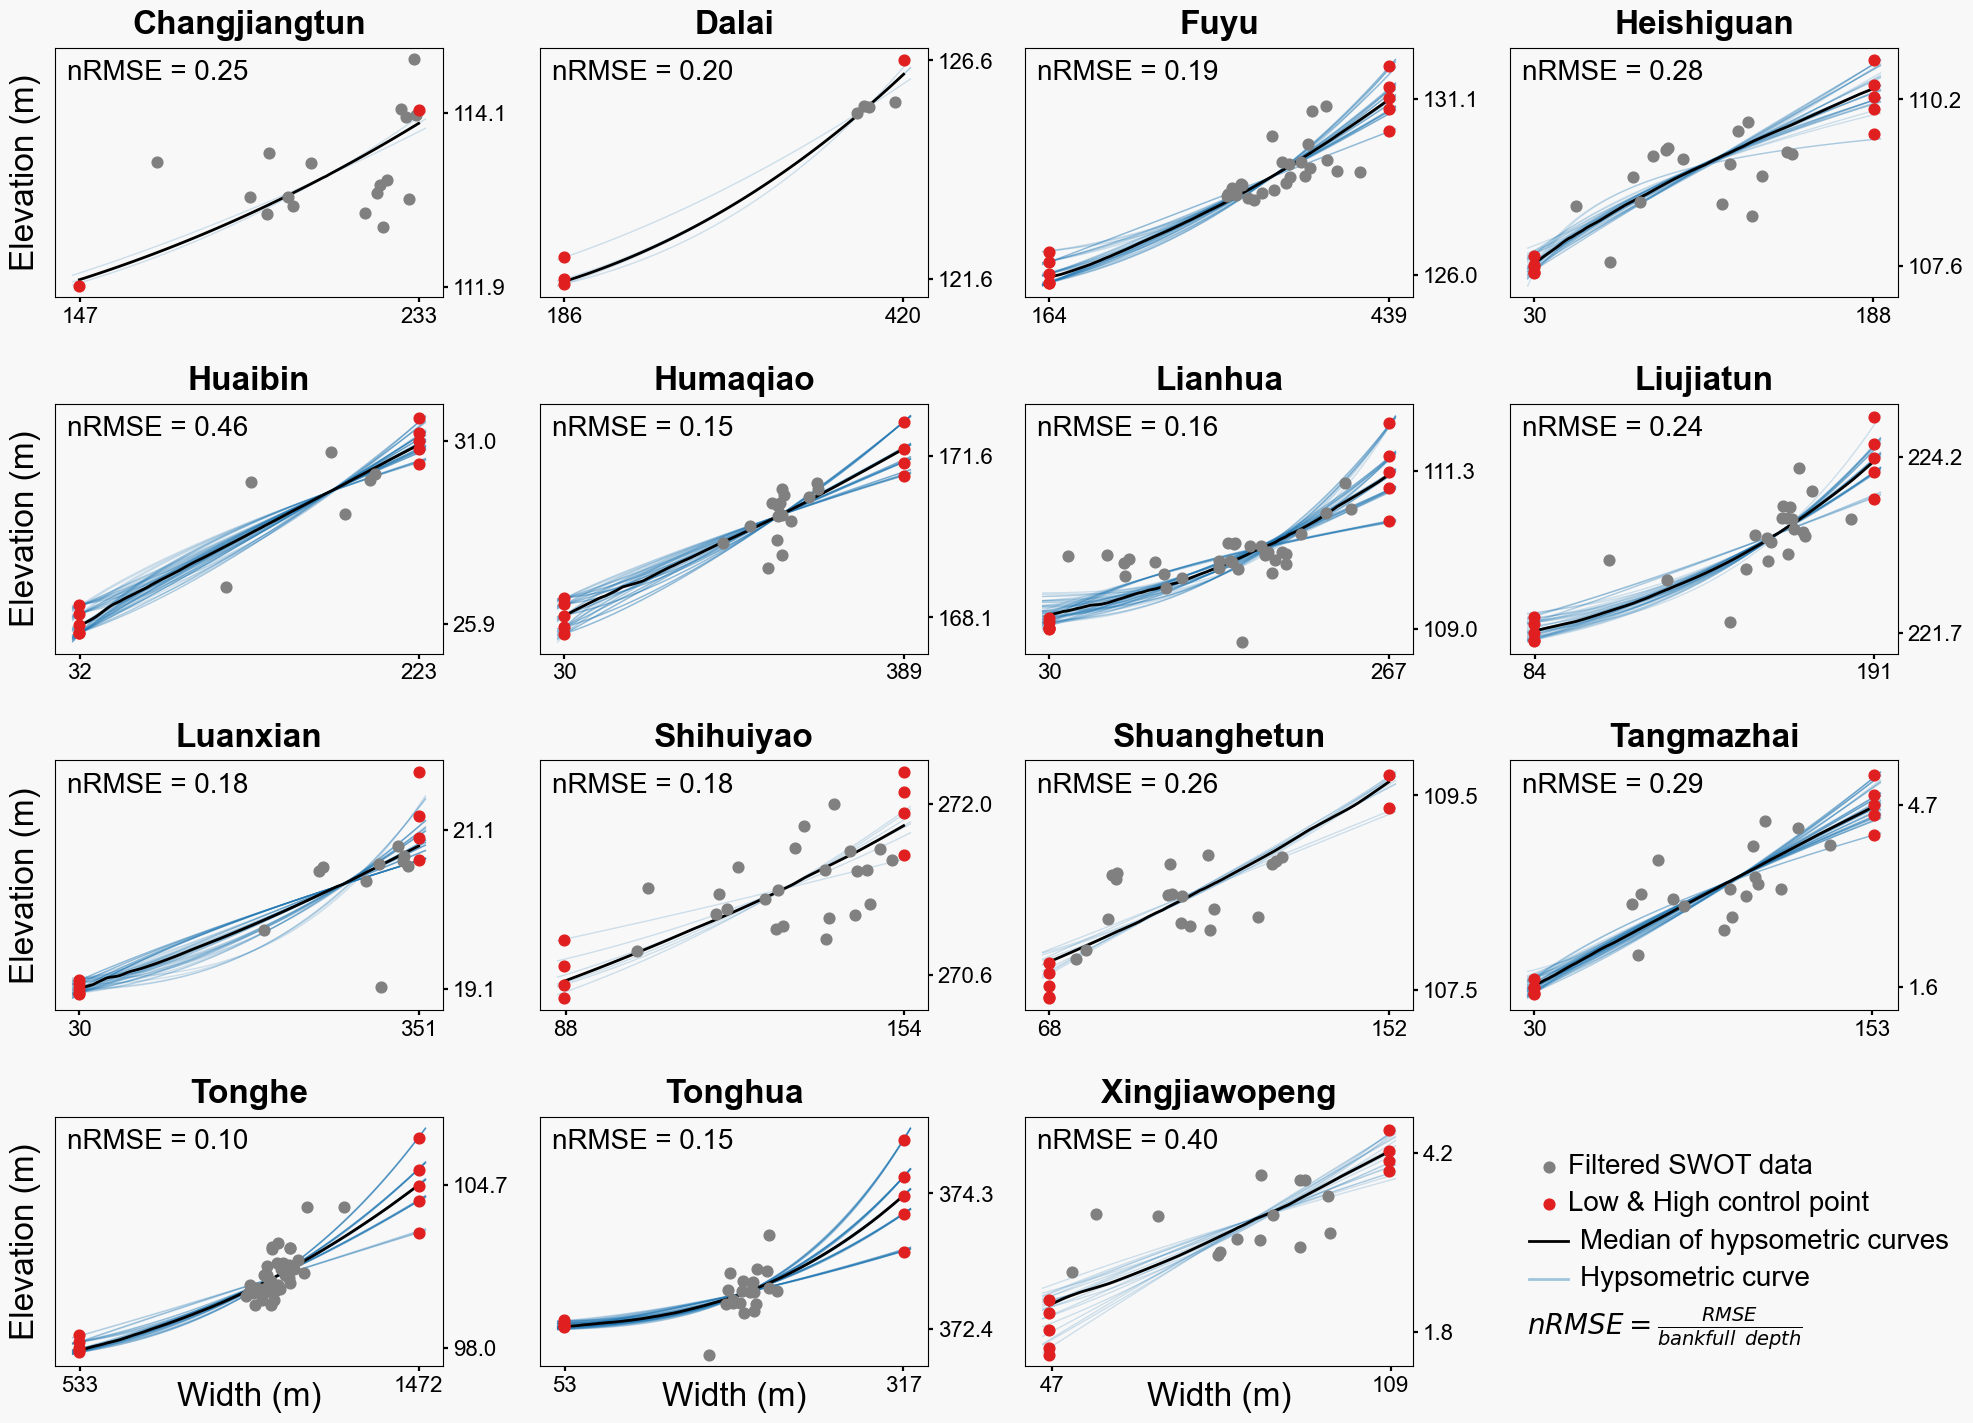

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['axes.titlepad'] = 10
#plt.rcParams['axes.labelpad'] = -2
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['xtick.major.width'] = 1.6
plt.rcParams['ytick.major.width'] = 1.6
plt.rcParams['axes.facecolor'] = '#F8F8F8'
plt.rcParams['figure.facecolor'] = '#F8F8F8'


N = 4
M = 4
BOUNDS = [0.1, 0.16, 0.8, 0.7]
MARGIN_LEFT, MARGIN_RIGHT, MARGIN_BOT, MARGIN_TOP = 0.015, 0.015, 0.04, 0.01
subplot_width = (1 - MARGIN_LEFT - MARGIN_RIGHT) / M

# 剩余高度空间用于子图（不再需要底部的ax_l）
remaining_height = 1 - MARGIN_TOP - MARGIN_BOT

# 新的 subplot_height
subplot_height = remaining_height / N

# 计算子图的位置
AXES_LEFT = MARGIN_LEFT + (np.arange(M) + BOUNDS[0]) * subplot_width
AXES_BOT = MARGIN_BOT + (np.arange(N) + BOUNDS[1]) * subplot_height
AXES_WIDTH = subplot_width * BOUNDS[2]
AXES_HEIGHT = subplot_height * BOUNDS[3]

# 创建图形
fig = plt.figure(figsize=(20, 15))

# 创建子图（只创建15个数据子图）
ax = [[None for j in range(M)] for i in range(N)]

# 创建15个数据子图
for i in np.arange(N - 1, -1, -1):
    for j in range(M):
        panel = (N - 1 - i) * M + j
        if panel < 15:  # 只创建前15个子图
            ax[i][j] = plt.axes([AXES_LEFT[j], AXES_BOT[i], AXES_WIDTH, AXES_HEIGHT])

# 第16个位置（i=0, j=3）用于图例
ax_legend = plt.axes([AXES_LEFT[3], AXES_BOT[0], AXES_WIDTH, AXES_HEIGHT])
ax_legend.set_facecolor('#F8F8F8')

df_swot_all = pd.read_csv('./3-process/2.swot-points-selection_iqr_node_1.5_noqa_VersionD.csv')
df_fit_all = pd.read_csv('./3-process/3.fit_proba_modified_q50_iqr_node_1.5_noqa_VersionD.csv')
df_fit_all = df_fit_all[~df_fit_all['stationid'].isin(['longmenzhen'])]
df_med_all = pd.read_csv('./3-process/4.hypso_med_modified_q50_iqr_node_1.5_noqa_VersionD.csv')
df_metrics = pd.read_csv('./4-validation/swot_hypso_metrics.csv').set_index('stationid')
stations = sorted(df_fit_all['stationid'].unique())
print('nstations',len(stations))

for panel in range(min(len(stations), 15)):  # 只绑定15个数据
    s = stations[panel]
    i, j = int(panel / M), panel % M
    # 转换为ax的索引（从上到下）
    ax_i = N - 1 - i
    
    df_swot = df_swot_all[df_swot_all['stationid']==s]
    df_fit = df_fit_all[df_fit_all['stationid']==s]
    df_med = df_med_all[df_med_all['stationid']==s]
    w_low, w_high = df_fit.iloc[0][['w_low','w_high']]
    df_swot = df_swot[(df_swot['width'] >= w_low) & (df_swot['width'] <= w_high)]
    h_low = df_fit['h_low'].unique()
    h_high = df_fit['h_high'].unique()

    ax[ax_i][j].scatter(df_swot['width'], df_swot['wse'], color='#808080', s=60, zorder=1)
    ax[ax_i][j].scatter(np.ones(len(h_low))*w_low, h_low, color='#E02020', s=60, zorder=2)
    ax[ax_i][j].scatter(np.ones(len(h_high))*w_high, h_high, color='#E02020', s=60, zorder=2)
    ax[ax_i][j].plot(df_med['width'], df_med['wse'], color='black', lw=2, zorder=0)

    x_min = w_low * 1.02 - w_high * 0.02
    x_max = w_high * 1.02 - w_low * 0.02
    plot_x = np.linspace(x_min, x_max, 100)
    for k in range(len(df_fit)):
        wse0, a, b = df_fit.iloc[k][['wse0','a','b']]
        plot_y = wse0 + a * plot_x**b
        ax[ax_i][j].plot(plot_x, plot_y, color='#1f77b4', lw=1, alpha=0.2, zorder=-1)

    ax[ax_i][j].set_xticks(np.round([w_low,w_high],0))
    ax[ax_i][j].set_yticks(np.round([np.median(h_low),np.median(h_high)],1))
    ax[ax_i][j].yaxis.set_ticks_position('right')
    ax[ax_i][j].set_title(s.capitalize(), fontweight='bold')
    
    # 底部一行添加x轴标签（panel 12, 13, 14）
    if panel >= 12: 
        ax[ax_i][j].set_xlabel('Width (m)', labelpad=-10)
    if j == 0: 
        ax[ax_i][j].set_ylabel('Elevation (m)', labelpad=10)

    x0, xmax = ax[ax_i][j].get_xlim()
    y0, ymax = ax[ax_i][j].get_ylim()
    fig_w = xmax - x0
    fig_h = ymax - y0
    ax[ax_i][j].set_xlim(x_min-0.05*(x_max-x_min), x_max+0.05*(x_max-x_min))
    ax[ax_i][j].text(x0+0.03*fig_w, y0+0.9*fig_h, 'nRMSE = %.2f'%df_metrics.loc[s,'nrmse'], ha='left', va='center')

# 在第16个子图位置绘制图例（9个元素，分5行）
ax_legend.set_xlim(0, 10)
ax_legend.set_ylim(0, 10)

# 第1行：灰色散点 + 文字
ax_legend.scatter([1], [8], color='#808080', s=60)
ax_legend.text(1.5, 8, 'Filtered SWOT data', ha='left', va='center')

# 第2行：红色散点 + 文字
ax_legend.scatter([1], [6.5], color='#E02020', s=60)
ax_legend.text(1.5, 6.5, 'Low & High control point', ha='left', va='center')

# 第3行：黑色线条 + 文字
ax_legend.plot([0.5, 1.5], [5, 5], color='black', lw=2)
ax_legend.text(1.8, 5, 'Median of hypsometric curves', ha='left', va='center')

# 第4行：蓝色线条 + 文字
ax_legend.plot([0.5, 1.5], [3.5, 3.5], color='#1f77b4', lw=2, alpha=0.4)
ax_legend.text(1.8, 3.5, 'Hypsometric curve', ha='left', va='center')

# 第5行：公式
ax_legend.text(4, 1.5, r'$nRMSE = \frac{RMSE}{bankfull\ \,depth}$', ha='center', va='center')

ax_legend.axis('off')

plt.savefig('Fig6.png', dpi=200)
print('Figure saved as Fig6.png')